Randomized Controlled Trials (aka. A/B tests) are the gold standard of establishing causal inference. RCTs strictly control for the randomization process and ensure equal distributions across covariates before rolling out the treatment. Thus, we can attribute the mean difference between the treatment and control groups to the intervention.

A/B tests are effective and only rely on mild assumptions, and the most important assumption is the Stable Unit Treatment Value Assumption, SUTVA. It states that the treatment and control units don’t interact with each other; otherwise, the interference leads to biased estimates.

# Business Scenario

A/B tests are effective and only rely on mild assumptions, and the most important assumption is the Stable Unit Treatment Value Assumption, SUTVA. It states that the treatment and control units don’t interact with each other; otherwise, the interference leads to biased estimates.

TikTok develops a new animal filter and wants to assess its effects on users. They are interested in two key metrics:

1. How does the filter affect user engagement (e.g., time spent on the app)?
2. How does the filter affect user retention (e.g., active)?

### Current Constraints

1. First, TikTok has no prior knowledge of its performance and prefers a small-scale study with minimal exposure. This is the desired approach because they can end the test promptly if the key metrics plummet (e.g., zero conversation rate in the treatment group).
2. It is an urgent issue in a timely manner, and TikTok wants an answer within two weeks.

### Stage 1 Pre-Test: Goal, Metrics, and Sample Size

- What is the goal of the test?

- How to measure success?

- How long should we run it?

Defining Goal: As a first step, we want to clarify the goal of the test and relay it back to the team. As mentioned, the study aims to measure user engagement and retention after rolling out the filter.

Measuring Success: Next, we move to the metrics and decide how to measure the success. As a social networking app, we adopt the time spent on the app to measure user engagement and two boolean variables, metric 1 and metric 2, indicating if the user is active after 1 day and 7 days, respectively.

Running the test:  How long should we run the test? A common strategy is to stop the experiment once we observe a statistically significant result (e.g., a small p-value) but this (p-hacking) is strongly opposed as it leads to biased results and false positives

Instead, we should run a power analysis and decide a minimum sample size, according to three parameters:

1. The Significane Level (or alpha)
2. Statistical Power
3. The Minimum Detectable effect (MDE)

1. The Significance Level, also denoted as alpha or α: the probability of rejecting a null hypothesis when it is true. By rejecting a true null hypothesis, we falsely claim there is an effect when there is no actual effect. Thus, it is also called the probability of False Positive (Type 1 Error)


2. Statistical Power: the probability of correctly identifying the effect when there is indeed an effect. Power = 1 — (False Negative or Type II Error)


3. The Minimum Detectable Effect (MDE): to find a widely agreed upon MDE, our data team sits down with the PM and decides the smallest acceptable difference is 0.1. In other words, the difference between the two groups scaled by the standard deviation needs to be at least 0.1. Otherwise, the release won’t compensate for the business costs incurred (e.g., engineers’ time, product lifecycle, etc.). For example, it won’t make any sense to roll out a new design if it only brings in a 0.000001% lift, even if it is statistically significant.

- Type I error is a ‘false positive,’ or the rejection of a true null hypothesis
- Type II error is a ‘false negative,’ or the failure to reject a true null hypothesis

Here is the bi-relationship between these three parameters and the required sample size:

Significance Level decreases → Larger Sample Size
Statistical Power increases → Larger Sample Size
The Minimum Detectable Effect decreases → Larger Sample Size

Typically, we set the significance level at 5% (or alpha = 5%) and statistical power at 80%. Thus, the sample size is calculated by the following formula:

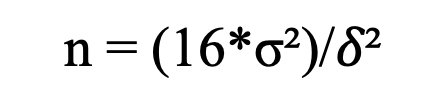

where:

σ²: sample variance

𝛿: the difference between the treatment and control groups (in percentage)


To obtain the sample variance (σ²), we typically run an A/A test that follows the same design thinking as an A/B test except assigning the same treatment to both groups.

What is an A/A test: Splitting the users into two groups and then assign the same treatment to both.

### Calculating Sample Size

In [4]:
from statsmodels.stats.power import TTestIndPower

# parameters for power analysis 
# effect_size has to be positive


alpha = 0.05
power = 0.8
effect = 0.1

# perform power analysis 

analysis = TTestIndPower()
result = analysis.solve_power(effect, power = power,nobs1= None, ratio = 1.0, alpha = alpha)
print('Sample Size: %.0f' % round(result))

Sample Size: 1571


We need 1571 for each variant. In terms of how long we should run the test, it depends on how much traffic the app receives. Then, we divide the daily traffic equally into these two variants and wait until collecting a sufficiently large sample size (≥1571).

As noted, TikTok is a tremendously popular app and has millions of DAUs. However, we are specifically targeting users who try out the new filters. Furthermore, the minimal exposure approach may take a few days to collect enough observations for the experiment.

**Best Practices**

- Understand the goal of the experiment and how to measure the success
- Run an A/A test to estimate the variance of the metric
- Run a power analysis to obtain the minimum sample size.

### Stage 2 During-Test: Data Collection

We roll out the test and initiate the data collection process. Here, we simulate the Data Generation Process (DGP) and artificially create variables that follow specific distributions. The true parameters are known to us, which comes in handy when comparing the estimated treatment effect to the true effects. In other words, we can evaluate the effectiveness of A/B tests and check to what extent they lead to unbiased results.

There are five variables to be simulated in our case study:

1. userid
2. version
3. minutes of plays
4. user engagement after 1 day (metric_1)
5. user engagement after 7 days (metric_2)

#### Variables 1 and 2: userid and version

We intentionally create 1600 control units and 1749 treated units to signal a potential Sample Ratio Mismatch (SRM)

In [9]:
import numpy as np

# variable 1: userid
user_id_control = list(range(1,1601))# 1600 control
user_id_treatment = list(range(1601,3350))# 1749 treated

# variable 2: version 
control_status = ['control']*1600
treatment_status = ['treatment']*1749

#### Variable 3: minutes of plays

We simulate variable 3 (“minutes of plays”) as a normal distribution with a μ of 30 minutes and σ² of 10. In specific, the mean for the control group is 30 minutes, and the variance is 10.

To recap, the effect parameter to the MDE is calculated as the difference between the two groups divided by the standard deviation (μ_1 — μ_2)/σ_squared = 0.1. According to the formula, we obtain μ_2 = 31. The variance is also 10.

In [15]:
# variable 3: minutes of plays, which follows a normal distribution with a μ of 30 minutes and σ² of 10 (central limit theorem)
# for control group
μ_1 = 30
σ_squared_1 = 10
np.random.seed(123)
minutes_control = np.random.normal(loc = μ_1, scale = σ_squared_1, size = 1600)

# for treatment group, which increases the user engagement by 
# according to the formula (μ_1 — μ_2)/σ_squared = 0.1, we obtain μ_2 = 31

μ_2 = 31
σ_squared_2 = 10
np.random.seed(123)
minutes_treat = np.random.normal(loc = μ_2, scale = σ_squared_2, size = 1749)

#### variable 4: user engagement after 1 day, metric_1

Our simulation shows that the control group has 30% active (True) and 70% inactive (False) users after 1 day (metric_1), while the treatment has 35% active and 65% inactive users, respectively.

In [16]:
# variable 4 user engagement after 1 day (metric_1)
# after day 1, treatment performs better than control --> to simulate novelty effect

Active_status = [True,False]

# control  
day_1_control = np.random.choice(Active_status, 1600, p=[0.3,0.7])

# treatment
day_1_treatment = np.random.choice(Active_status, 1749, p=[0.35,0.65])

#### variable 5: user engagement after 7 day, metric_2

The simulation data shows the control group has a 35% active user rate, while the treatment has a 25% after 7 days

In [17]:
# variable 5 user engagement after 7 day (metric_2)
# after day 7, control > treatment --> the novelty effect diminishes & performance reversed

Active_status = [True,False]

# control  
day_7_control = np.random.choice(Active_status, 1600, p=[0.35,0.65])

# treatment
day_7_treatment = np.random.choice(Active_status, 1749, p=[0.25,0.75])

The true data contains a reversed pattern: the treatment performs better in the short term but the control group comes back and stands out after one week.

Let’s check if the A/B test picks up the reversed signa

In [18]:
# control data

import pandas as pd
raw_control = {'user_id':user_id_control,
                 'version':control_status,
               'minutes_play':minutes_control,
               'day_1_active':day_1_control,
               'day_7_active':day_1_control
                }

control_group = pd.DataFrame(data = raw_control)
control_group

,user_id,version,minutes_play,day_1_active,day_7_active
0,1,control,19.143694,False,False
1,2,control,39.973454,True,True
2,3,control,32.829785,False,False
3,4,control,14.937053,False,False
4,5,control,24.213997,False,False
...,...,...,...,...,...
1595,1596,control,27.154466,False,False
1596,1597,control,46.414042,True,True
1597,1598,control,41.523560,True,True
1598,1599,control,23.981909,False,False


In [20]:
# treatment data 
raw_treatment = {'user_id':user_id_treatment,
                 'version':treatment_status,
               'minutes_play':minutes_treat,
               'day_1_active':day_1_treatment,
               'day_7_active':day_7_treatment
                }

treatment_group = pd.DataFrame(data = raw_treatment)
treatment_group

,user_id,version,minutes_play,day_1_active,day_7_active
0,1601,treatment,20.143694,False,False
1,1602,treatment,40.973454,True,False
2,1603,treatment,33.829785,True,True
3,1604,treatment,15.937053,False,False
4,1605,treatment,25.213997,False,True
...,...,...,...,...,...
1744,3345,treatment,23.053563,False,False
1745,3346,treatment,21.755798,False,True
1746,3347,treatment,45.081771,True,True
1747,3348,treatment,37.187168,True,True


In [21]:
# combine these two datasets
two_datasets = control_group.append(treatment_group)

# randomize the orders using df.sample(frac=1)
# The frac keyword argument: specifies the fraction of rows to return in the random sample
# so frac=1 means return all rows (in random order)

final_data = two_datasets.sample(frac=1)

C:\Users\aruna\AppData\Local\Temp\ipykernel_11376\1694145550.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  two_datasets = control_group.append(treatment_group)


In [22]:
final_data.head()

,user_id,version,minutes_play,day_1_active,day_7_active
30,1631,treatment,28.443806,True,False
1097,1098,control,43.093510,False,False
1313,2914,treatment,36.196111,False,False
791,792,control,37.740000,False,False
632,633,control,9.476016,False,False


**Best Practices**

- Don’t end your A/B tests prematurely after witnessing some initial positive effects.
- No early stopping!
- No p-hacking!
- Instead, end it when you have reached the minimum sample size.

### Stage 3 After-Test: Data Analysis

After collecting enough data, we move to the last stage of experiments, which is data analysis. As a first step, it would be beneficial to check how many users fell into each variant.

In [24]:
# calculate the number of users in each version
final_data.groupby('version')['user_id'].count()

version
control      1600
treatment    1749
Name: user_id, dtype: int64

It appears to be a suspicious variant split: 1600 control units but 1749 treatment units. The treatment assignment process looks suspicious at face value as more users are assigned to the treatment than the control.

To formally check for the SRM, we conduct a chi-square test between the actual split and the expected split of the treated and control units

In [35]:
from scipy.stats import chisquare 

chisquare([1600,1749], f_exp = [1674.5,1674.5])

Power_divergenceResult(statistic=6.629143027769484, pvalue=0.01003235193083798)

We set the alpha level at 0.001 to test SRM. Since the p-value is 0.01, we fail to reject the null hypothesis and conclude there is no evidence of SRM. In contrast to our intuition, statistical tests conclude that the treatment assignment works as expected.

**Plot the Distribution of Minutes Played for Each Group**

Since the variable minutes_play is a float, we have to round it up to the nearest integers before grouping.

Text(0, 0.5, 'User Count')

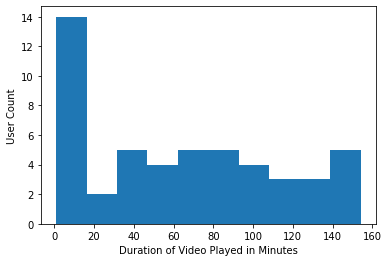

In [39]:
%matplotlib inline

final_data['minutes_play_integers'] = round(final_data['minutes_play'])
plot_df = final_data.groupby('minutes_play_integers')['user_id'].count()

# Plot the distribution of players that played 0 to 50 minutes

ax = plot_df.head(n = 50).plot(x = 'minutes_play_integers', y = 'user_id', kind = 'hist')
ax.set_xlabel('Duration of Video Played in Minutes')
ax.set_ylabel('User Count')

**Metric 1: 1-day retention by AB-Group**

In [41]:
# 1-day retention

final_data['day_1_active'].mean()
0.3248730964467005

0.3248730964467005

After 1 day, the overall active user rate, on average, hovers around 32.5%.

In [43]:
# 1-day retention by group
final_data.groupby('version')['day_1_active'].mean()

version
control      0.293125
treatment    0.348771
Name: day_1_active, dtype: float64

After taking a closer look, the control group has 29.7% active users, and the treatment has 35%

Naturally, we are interested in the following questions:

- Is the higher retention rate in the treatment group statistically significant?

- What is its variability?

- If we repeat the process for 10,000 times, how often do we observe at least as extreme values?

Bootstrap can answer these questions. It is a resample strategy that repeatedly samples from the original data with replacements. According to the Central Limit Theorem, the distribution of the resample means approximately normally distributed

<AxesSubplot:ylabel='Density'>

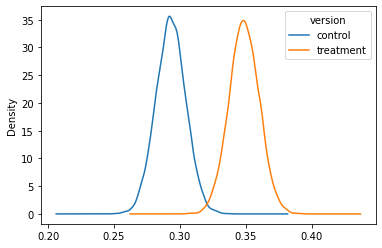

In [44]:
# solution: bootstrap
boot_means = []

# run the simulation for 10k times 
for i in range(10000):
    #frac=1 means randomize the order of all rows 
    boot_sample = final_data.sample(frac=1,replace=True).groupby('version')['day_1_active'].mean()
    boot_means.append(boot_sample)

# a Pandas DataFrame
boot_means = pd.DataFrame(boot_means)

# kernel density estimate
boot_means.plot(kind = 'kde')

In [45]:
# create a new column, diff, which is the difference between the two variants, scaled by the control group
boot_means['diff'] = (boot_means['treatment'] - boot_means['control'])/boot_means['control']*100

In [46]:
boot_means['diff']

day_1_active    17.970394
day_1_active    16.338012
day_1_active    21.344125
day_1_active    29.290652
day_1_active    28.682724
                  ...    
day_1_active    17.016447
day_1_active    17.300397
day_1_active    19.224083
day_1_active    20.849796
day_1_active    18.693185
Name: diff, Length: 10000, dtype: float64

Text(0.5, 0, '% diff in means')

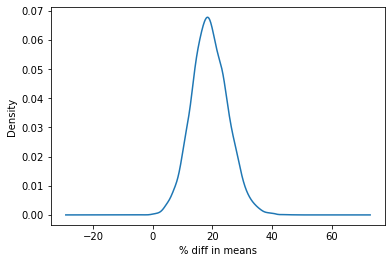

In [47]:
# plot the bootstrap sample difference 
ax = boot_means['diff'].plot(kind = 'kde')
ax.set_xlabel("% diff in means")

In [50]:
boot_means[boot_means['diff'] > 0]

# p value 
p = (boot_means['diff'] > 0).sum() / len(boot_means)
p

0.9998

After bootstrapping 10,000 times, the treatment has a higher 1-day retention rate 99.98% of the time.
The test result is consistent with our original simulated data.

**Metric 7: 7-day retention by AB-Group**

In [57]:
boot_7d = []

for i in range(10000):
    #set frac=1 --> sample all rows
    boot_mean = final_data.sample(frac=1,replace=True).groupby('version')['day_7_active'].mean() 
    boot_7d.append(boot_mean)
    
boot_7d = pd.DataFrame(boot_7d)

boot_7d['diff'] = (boot_7d['treatment'] - boot_7d['control'])/boot_7d['control'] *100

Text(0.5, 0, '% diff in means')

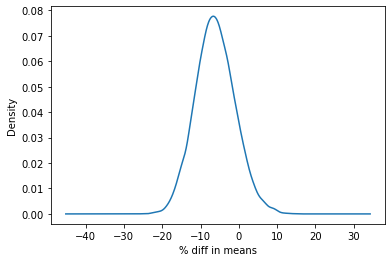

In [58]:
# Ploting the bootstrap % difference

ax = boot_7d['diff'].plot(kind = 'kde')
ax.set_xlabel("% diff in means")

In [59]:
# Calculating the probability that 7-day retention is greater when the gate is at level 30

p = (boot_7d['diff']>0).sum()/len(boot_7d)
1-p

0.8826

On the 7-day metric, the control obviously has a better user retention rate 88.26% of the time, also consistent with the original data.

The reversed pattern between 1-day and 7-day metrics supports the novelty effect as users become activated and intrigued by the new design, not because the change actually improves engagement. The novelty effect is popular in consumer-side A/B tests.

**Best Practices**

- SRM is a real concern. We apply a chi-square test to formally test for the SRM. If the p-value is smaller than the threshold (α = 0.001), the randomization process does not work as expected

- SRM introduces selection bias that invalidates any test results

- Three fundamental statistical concepts to master: SRM, Chi-Square Test, and Bootstrap

- Compare short-term and long-term metrics to evaluate the novelty effect

**Conclusion**

An A/B test requires extensive statistical knowledge and careful attention to detail. There are thousands of ways of ruining your test results but only one way to do it correctly. Follow the best practices described before-, during-, and after- the experiments and set up your experiments for success.